Apply the Optimization code to predict dolphin hunting parties of [3, 4, 6, 8, 10] with the conditions that the cost function increase by square of the pairwise distance if the dolphins are too far apart, and increases by inverse square of the pairwise distance if they are too close together.

0.0 0 2920.139303394592 shrink
0.0 0 644.1579976232473 reflect
0.0 0 398.2187756017894 reflect
0.0 0 204484.70498207834 shrink
0.0 0 1916.9291210811768 reflect
0.0 0 1407.333521966449 reflect
0.0 0 1103.9632554197055 reflect
0.0 0 755.161231857951 reflect
0.0 0 461.96342599284554 contract
0.0 0 356.57484608245807 shrink
0.0 0 171.06924916850016 reflect
0.0 0 131.8996721734771 reflect
0.0 0 92.96386347844566 contract2
0.0 0 71.54819396266006 contract2
0.0 0 59.774783810940534 reflect
0.0 0 544.6452208531224 shrink
0.0 0 479.7929395573151 reflect
0.0 0 374.4157882590117 contract2
0.0 0 166.12954548611327 reflect
0.0 0 72.57622473310605 contract
0.0 0 334.8841987350948 shrink
0.0 0 216.56279493398128 reflect
0.0 0 168.57992414030736 reflect
0.0 0 132.8402685504689 reflect
0.0 0 99.64825943201353 reflect
0.0 0 28.807369350845775 reflect
0.0 0 22.43453831614497 reflect
0.0 0 18.570874949974684 reflect
0.0 0 14.752227136955513 reflect
0.0 0 13.722936130858365 reflect
0.0 0 11.478080765294882

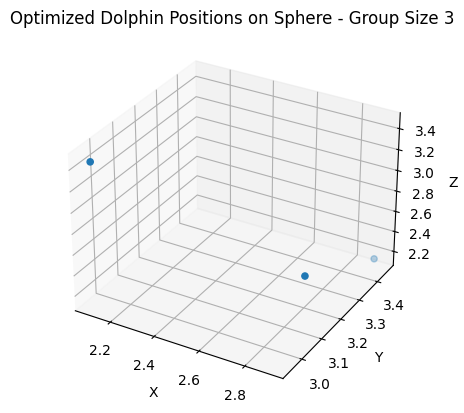

0.0 0 4723993.531425347 shrink
0.0 0 26359.550016298937 reflect
0.0 0 6079.927688111822 reflect
0.0 0 2671.5581595166905 reflect
0.0 0 1509.3953958551363 contract2
0.0 0 943.6211688068022 contract2
0.0 0 665.1527246239517 contract2
0.0 0 171528.29630292658 shrink
0.0 0 30240.532301705192 reflect
0.0 0 11667.420406224957 reflect
0.0 0 6334.067886081172 reflect
0.0 0 5210.48619958647 contract2
0.0 0 3839.767077779125 reflect
0.0 0 3185.1596387551494 reflect
0.0 0 2476.1317354328553 reflect
0.0 0 1776.2029144027977 reflect
0.0 0 1293.1643333982238 reflect
0.0 0 17535.312295657463 shrink
0.0 0 13551.51173554188 reflect
0.0 0 9867.97467935189 reflect
0.0 0 967.0977069511051 reflect
0.0 0 3880.0859366615405 shrink
0.0 0 2769.253627504567 reflect
0.0 0 1629.705143645544 reflect
0.0 0 1100.8969847398535 contract2
0.0 0 705.0077088740047 contract2
0.0 0 31902.35920767268 shrink
0.0 0 8475.624434943793 contract
0.0 0 7099.393723741847 reflect
0.0 0 6334.444681442981 contract
0.0 0 191791.2277803

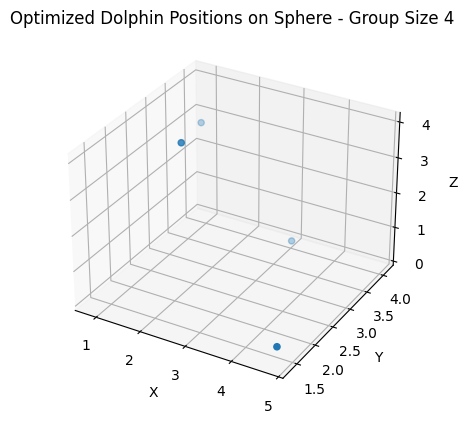

0.0 0 29027.7569540263 shrink
0.0 0 22368.74057233601 reflect
0.0 0 18770.31337035231 reflect
0.0 0 14893.038766910804 reflect
0.0 0 11931.87190036775 reflect
0.0 0 8157.979429763836 reflect
0.0 0 4943.503420420125 reflect
0.0 0 4578.080356458877 reflect
0.0 0 4383.468221216707 reflect
0.0 0 38457.01772160518 shrink
0.0 0 3541.7724481490645 contract2
0.0 0 3128.1790136693985 contract2
0.0 0 2562.9028856121217 reflect
0.0 0 2585319.669039228 shrink
0.0 0 84927.86091706427 contract
0.0 0 27737.406834349014 reflect
0.0 0 20999.42338982262 reflect
0.0 0 17845.39177542446 reflect
0.0 0 15015.575822533034 reflect
0.0 0 11371.712967327327 contract2
0.0 0 7395.007055590527 reflect
0.0 0 10102746.588567838 shrink
0.0 0 1590639.434815027 reflect
0.0 0 636405.7950398297 reflect
0.0 0 30074.87707673128 reflect
0.0 0 8766.127273721813 reflect
0.0 0 7429.751331296824 reflect
0.0 0 6141.848737652483 contract2
0.0 0 4937.420680750131 contract2
0.0 0 4163.021440492716 contract2
0.0 0 61628.324858782034

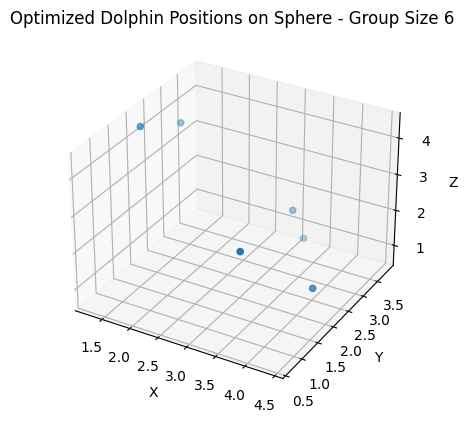

0.0 0 9573499.769755498 shrink
0.0 0 2701113.185572085 reflect
0.0 0 202211.01751523695 reflect
0.0 0 168765.3870876278 reflect
0.0 0 139087.97926345794 contract2
0.0 0 11512848.542473333 shrink
0.0 0 129390.05007582613 reflect
0.0 0 97955.71979874822 reflect
0.0 0 85030.99000861449 reflect
0.0 0 70241.82738285302 contract2
0.0 0 57779.119222357054 reflect
0.0 0 46142.77041374876 reflect
0.0 0 28680.216406622323 reflect
0.0 0 23552.45653440537 reflect
0.0 0 21439.399485109036 reflect
0.0 0 19837.789271313286 reflect
0.0 0 21635873.24842892 shrink
0.0 0 152999.0108368495 reflect
0.0 0 109783.73936141642 reflect
0.0 0 97424.95540998036 reflect
0.0 0 97078.07288995526 contract2
0.0 0 87652.65431152497 reflect
0.0 0 1363530.7684978247 shrink
0.0 0 357153.85738545 reflect
0.0 0 227371.58320519523 reflect
0.0 0 153891.38812836245 reflect
0.0 0 88577.1899159366 reflect
0.0 0 44053.43604402916 contract2
0.0 0 23249.91612943765 reflect
0.0 0 19771.619949123127 contract2
0.0 0 17049.989634701342

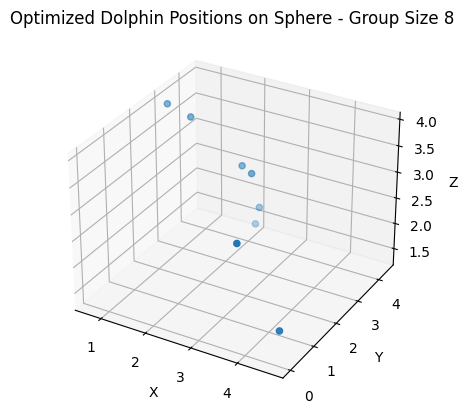

0.0 0 2821673.724043501 shrink
0.0 0 998827.9348099981 reflect
0.0 0 666564.0057846403 reflect
0.0 0 335266.7681803202 contract2
0.0 0 279397.6900482088 reflect
0.0 0 203340.79106953513 reflect
0.0 0 139489.71482739164 contract
0.0 0 110851.71075507437 reflect
0.0 0 88961.97464794091 reflect
0.0 0 69119.5053539536 reflect
0.0 0 52283.27337720288 reflect
0.0 0 39349.14772419345 reflect
0.0 0 35233.982989008204 contract2
0.0 0 29270.69265699822 reflect
0.0 0 24362.85615591729 contract2
0.0 0 22580.035451128082 reflect
0.0 0 2954583.91263101 shrink
0.0 0 1226505.6418977322 reflect
0.0 0 679706.3168167621 reflect
0.0 0 450693.6249399845 reflect
0.0 0 296794.517581724 reflect
0.0 0 175238.03740550706 reflect
0.0 0 145155.94263730553 reflect
0.0 0 138709.83890914035 reflect
0.0 0 121528.55271931867 reflect
0.0 0 114040.31805541835 shrink
0.0 0 72484.81299666554 reflect
0.0 0 58568.21595130943 reflect
0.0 0 38006.64120022083 contract2
0.0 0 32099.497066769072 reflect
0.0 0 28240.537554497216 

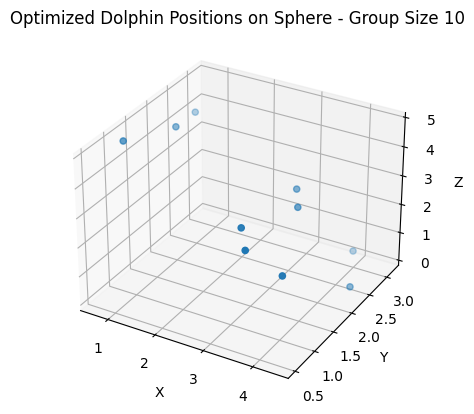

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class Nelder_Mead:
    def __init__(self, dim, distance_cost_func, param=None):
        self.dim = dim


        self.simplex = np.zeros(dim*(dim + 1))
        self.simplex = np.reshape(self.simplex, (dim + 1, dim))

        self.param = param
        self.distance_cost_func = distance_cost_func
        self.val = np.zeros(dim + 1)
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 2.0
        self.delta = 0.5


    def get(self, index, entry=None):
        if entry is None:
            return self.val[index], self.simplex[index]
        else:
            self.simplex[index] = np.array(entry)
            self.val[index] = self.calculate_cost(entry)
            return self.val[index], self.simplex[index]

    def __getitem__(self, index):
        return self.get(index)

    def __setitem__(self, index, entry):
        return self.get(index, entry)

    def max_min(self):
        indices = np.argsort(self.val)
        return indices[-1], indices[0]

    def sorted_index(self, index):
        indices = np.argsort(self.val)
        return indices[index]

    def centroid(self):
        max, min = self.max_min()
        p_bar = np.zeros(self.dim)
        for i in range(max):
            p_bar += self.simplex[i]
        for i in range(max + 1, self.dim + 1):
            p_bar += self.simplex[i]

        p_bar = p_bar/self.dim
        return p_bar

    def reflect(self, p_bar, p):
        return (1 + self.alpha) * p_bar - self.alpha * p

    def expand(self, p_bar, p):
        return self.gamma * p + (1 - self.gamma) * p_bar

    def contract(self, p_bar, p):
        return self.beta * p + (1 - self.beta) * p_bar

    def point_shrink(self, pl, p):
        return self.delta * p + (1 - self.delta) * pl

    def rmsd(self):
        average = 0.0
        square_average = 0.0
        for entry in self.val:
            average += entry
            square_average += entry * entry
        average /= self.dim
        square_average /= self.dim
        return np.sqrt(np.abs(square_average - average*average))

    def calculate_cost(self, entry):
        if self.param is None:
            return self.distance_cost_func(entry)
        else:
            return self.distance_cost_func(entry, self.param)

    def nelder_mead_step(self):
        max_original, min_original = self.max_min()
        max_second = self.sorted_index(-2)
        p_bar = self.centroid()
        p_r = self.reflect(p_bar, self.simplex[max_original])

        val_r = self.calculate_cost(p_r)

        if val_r >= self.val[min_original] and val_r < self.val[max_second]:
            self.get(max_original, p_r)
            return self.val[min_original], min_original, self.rmsd(), 'reflect'

        if val_r < self.val[min_original]:
            p_ex = self.expand(p_bar, p_r)
            val_ex = self.calculate_cost(p_ex)

            if val_ex < val_r:
                self.get(max_original, p_ex)
                return val_ex, max_original, self.rmsd(), 'expand'
            else:
                self.get(max_original, p_r)
                return val_r, max_original, self.rmsd(), 'reflect'

        if val_r >= self.val[max_second]:
            if val_r < self.val[max_original]:
                p_c = self.contract(p_bar, p_r)
                val_c = self.calculate_cost(p_c)
                if val_c < val_r:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
            if val_r >= self.val[max_original]:
                p_c = self.contract(p_bar, self.simplex[max_original])
                val_c = self.calculate_cost(p_c)
                if val_c < self.val[max_original]:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract2'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
    def initialize_simplex(self):
            # Initialize simplex based on the number of dolphins
        self.simplex = np.random.rand(self.dim + 1, self.dim)


    def optimize(self):
        rms = 1.0
        while rms > 1e-4:
            val, index, rms, step_name = self.nelder_mead_step()
            print(val, index, rms, step_name)
        return self.simplex[index]




def distance_cost_func(dolphins):
    far_apart_cost = 0.01 * sum(np.square(np.linalg.norm(d1 - d2)) for i, d1 in enumerate(dolphins) for j, d2 in enumerate(dolphins) if i != j and np.linalg.norm(d1 - d2) > 2)
    too_close_cost = 0.01 * sum(1 / np.square(np.linalg.norm(d1 - d2)) for i, d1 in enumerate(dolphins) for j, d2 in enumerate(dolphins) if i != j and np.linalg.norm(d1 - d2) < 1)
    return far_apart_cost + too_close_cost

def calculate_z_coordinates(x):
    return np.sin(np.sqrt(np.sum(x**2, axis=1))) * 10



def normalize_to_sphere(x, num_dolphins, radius=1.0):
    x = x.reshape(num_dolphins, -1)
    norm = np.linalg.norm(x, axis=1)
    normalized_x = radius * x / norm[:, np.newaxis]
    return normalized_x.flatten()

if __name__ == '__main__':
    np.random.seed()  # Set seed for reproducibility

    group_sizes = [3, 4, 6, 8, 10]

    for num_dolphins in group_sizes:
        nm = Nelder_Mead(num_dolphins * 3, distance_cost_func)
        nm.initialize_simplex()
        x = nm.optimize()

        # Normalize to ensure positions are on a sphere with radius 5.0 (adjust as needed)
        x = normalize_to_sphere(x, num_dolphins, radius=5.0)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(x[::3], x[1::3], x[2::3])

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Optimized Dolphin Positions on Sphere - Group Size {num_dolphins}')

        plt.show()